In [3]:
import torch
from torch import nn
import matplotlib.pyplot as plt
torch.__version__

'2.1.0.post100'

## What we want to do

1. Turn your data, whatever it is, into numbers (a representation).
1. Pick or build a model to learn the representation as best as possible.

## Preparing and load data - using linear regression to create known parameter


In [8]:
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.02
X = torch.arange(start,end,step)
y = weight * X + bias
X[:10],y[:10]

(tensor([0.0000, 0.0200, 0.0400, 0.0600, 0.0800, 0.1000, 0.1200, 0.1400, 0.1600,
         0.1800]),
 tensor([0.3000, 0.3140, 0.3280, 0.3420, 0.3560, 0.3700, 0.3840, 0.3980, 0.4120,
         0.4260]))

In [9]:
# building a model that can learn the relationship between X (features) and y (labels).
# Create train/test split
train_split = int(0.8 * len(X))  # 80%
X_train, y_train = X[:train_split],y[:train_split] 
X_test, y_test = X[train_split:],y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)


(40, 40, 10, 10)

In [10]:
def plot_predictions(train_data=X_train, 
                     train_labels=y_train, 
                     test_data=X_test, 
                     test_labels=y_test, 
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
  
  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

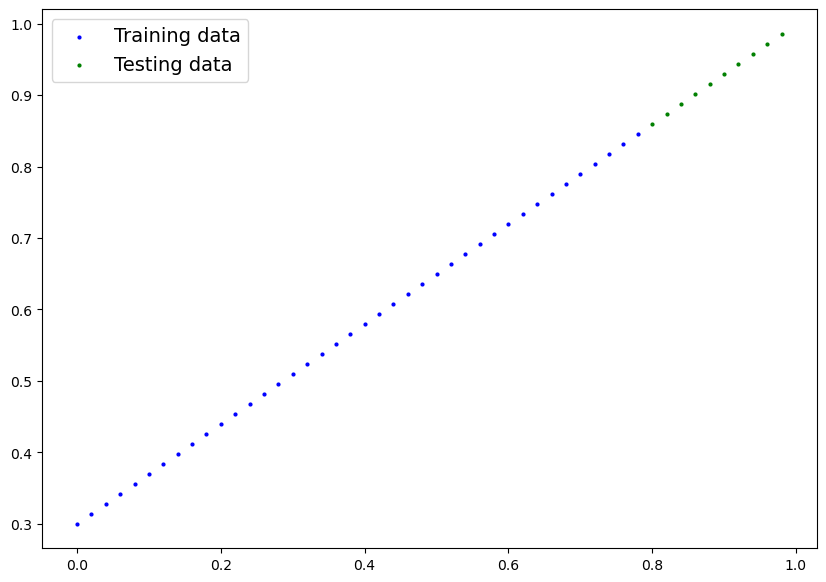

In [11]:
plot_predictions()

In [13]:
class LinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        # discover the parameters using random data for initialization and gradian descent to find the best value.
        self.weights = nn.Parameter(torch.randn(1,requires_grad=True,dtype=torch.float))
        self.bias = nn.Parameter(torch.randn(1,requires_grad=True,dtype=torch.float))
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x * self.weights + self.bias

In [17]:
torch.manual_seed(42)
m0 = LinearRegression()
list(m0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

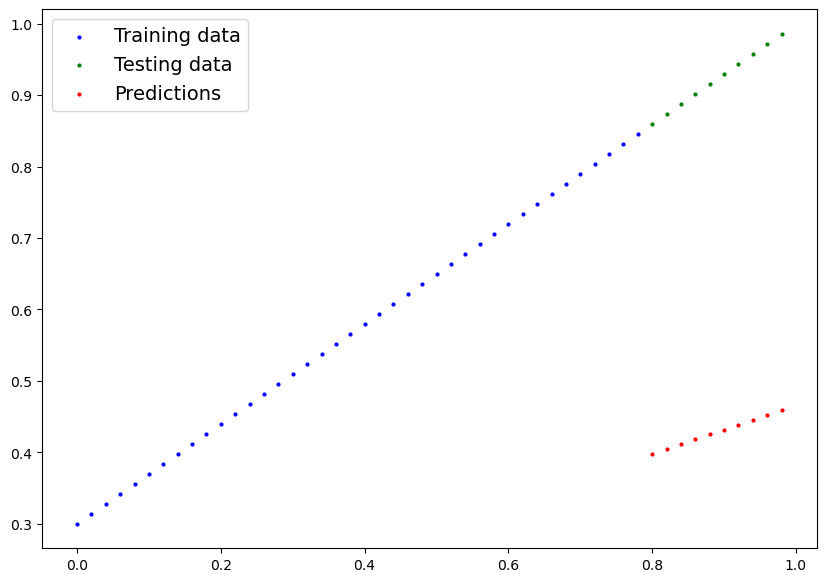

In [20]:
# check model prediction on test data
with torch.inference_mode(): 
    y_preds = m0(X_test)
plot_predictions(predictions=y_preds)

In [21]:
y_test - y_preds

tensor([0.4618, 0.4691, 0.4764, 0.4836, 0.4909, 0.4982, 0.5054, 0.5127, 0.5200,
        0.5272])

In [29]:
# creating a loss function and optimizer: need somethinf to update model's parameters on its own
# MAE measures the absolute difference between two points (predictions and labels) and 
# then takes the mean across all examples.
loss_fn = nn.L1Loss() # MAE loss is same as L1Loss

# Create the optimizer
optimizer = torch.optim.SGD(params=m0.parameters(), # parameters of target model to optimize
                            lr=0.01) # learning rate



# Set the number of epochs (how many times the model will pass over the training data)
epochs = 200
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    m0.train() 
    y_pred = m0(X_train)

    # 2. Calculate the loss (how different are our models predictions to the ground truth)
    loss = loss_fn(y_pred, y_train)
    # 3. Zero grad of the optimizer
    optimizer.zero_grad()
    # 4. Loss backwards
    loss.backward()
    # 5. Progress the optimizer
    optimizer.step()
    # Testing
    m0.eval()
    with torch.inference_mode():
        test_pred = m0(X_test)

        # 2. Caculate loss on test data
        test_loss = loss_fn(test_pred, y_test.type(torch.float)) 
        if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")
    

Epoch: 0 | MAE Train Loss: 0.024110015481710434 | MAE Test Loss: 0.05536102131009102 
Epoch: 10 | MAE Train Loss: 0.020677711814641953 | MAE Test Loss: 0.04777535796165466 
Epoch: 20 | MAE Train Loss: 0.017245199531316757 | MAE Test Loss: 0.0395028181374073 
Epoch: 30 | MAE Train Loss: 0.013806397095322609 | MAE Test Loss: 0.031230276450514793 
Epoch: 40 | MAE Train Loss: 0.010375780053436756 | MAE Test Loss: 0.023644620552659035 
Epoch: 50 | MAE Train Loss: 0.0069415816105902195 | MAE Test Loss: 0.0153720797970891 
Epoch: 60 | MAE Train Loss: 0.0035027742851525545 | MAE Test Loss: 0.007099539041519165 
Epoch: 70 | MAE Train Loss: 0.0025885060895234346 | MAE Test Loss: 0.008447891101241112 
Epoch: 80 | MAE Train Loss: 0.0025885060895234346 | MAE Test Loss: 0.008447891101241112 
Epoch: 90 | MAE Train Loss: 0.0025885060895234346 | MAE Test Loss: 0.008447891101241112 
Epoch: 100 | MAE Train Loss: 0.0025885060895234346 | MAE Test Loss: 0.008447891101241112 
Epoch: 110 | MAE Train Loss: 0.0

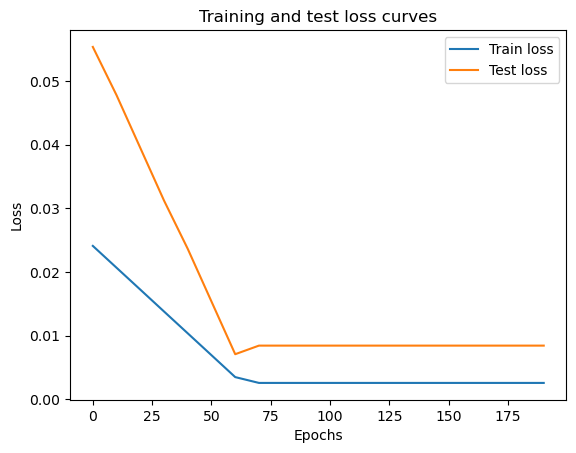

In [30]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [31]:
# Find our model's learned parameters
print("The model learned the following values for weights and bias:")
print(m0.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('weights', tensor([0.6951])), ('bias', tensor([0.2993]))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


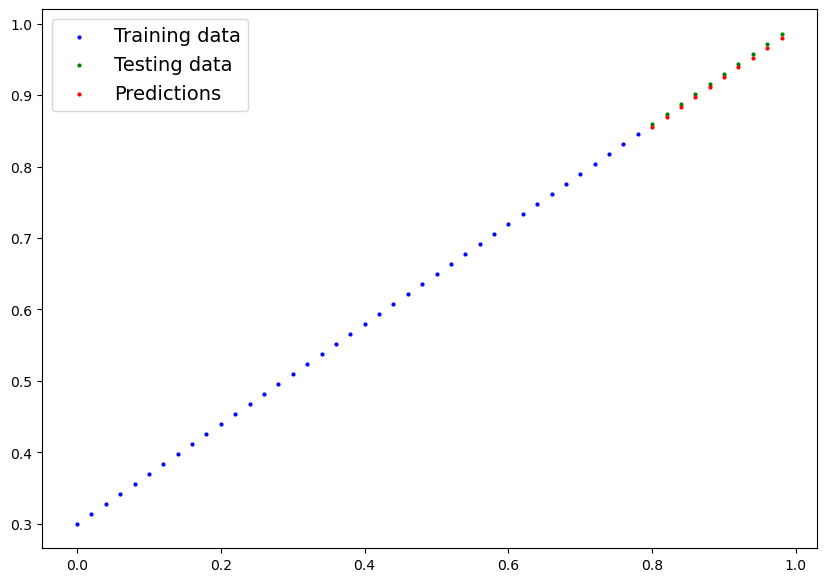

In [32]:
# 1. Set the model in evaluation mode
m0.eval()

# 2. Setup the inference mode context manager
with torch.inference_mode():
  # 3. Make sure the calculations are done with the model and data on the same device
  # in our case, we haven't setup device-agnostic code yet so our data and model are
  # on the CPU by default.
  # model_0.to(device)
  # X_test = X_test.to(device)
  y_preds = m0(X_test)
y_preds
plot_predictions(predictions=y_preds)

In [33]:
# save model with pickle
from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "linear_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=m0.state_dict(), # only saves the models learned parameters
           f=MODEL_SAVE_PATH) 

Saving model to: models/linear_model_0.pth
